In [13]:
# Cell 1: Import thư viện và Tải lại "bộ não"
import joblib
import pandas as pd
import os
import numpy as np
from scipy.sparse import hstack
import re
import string

# --- ĐƯỜNG DẪN ĐẾN CÁC FILE ĐÃ LƯU ---
model_folder = '../models'
model_path = os.path.join(model_folder, 'xgboost_model.pkl')
tfidf_path = os.path.join(model_folder, 'tfidf_vectorizer.pkl')
numeric_cols_path = os.path.join(model_folder, 'numeric_features_cols.pkl')
ohe_path = os.path.join(model_folder, 'one_hot_encoder.pkl')

# --- TẢI LẠI CÁC THÀNH PHẦN ---
print("Đang tải lại mô hình và các thành phần đã lưu...")
xgb_model_loaded = joblib.load(model_path)
tfidf_loaded = joblib.load(tfidf_path)
numeric_features_cols_loaded = joblib.load(numeric_cols_path)
ohe_loaded = joblib.load(ohe_path)
print("Tải thành công!")

Đang tải lại mô hình và các thành phần đã lưu...
Tải thành công!


In [10]:
# Cell 2 (Phiên bản Sửa lỗi)

# Tải bộ dữ liệu kiểm thử mới (đã có 2 cột 'text_combined' và 'label')
test_df_new = pd.read_csv('../data/clear/my_cleaned_phishing_data.csv') 
# ^^ LƯU Ý: Đảm bảo bạn đang dùng đúng file. 
# Tôi đang dùng file mà chúng ta đã tạo ra trước đó.
# Nếu bạn dùng file khác, hãy thay đổi tên file ở đây.

# --- LÀM SẠCH VÀ CHUẨN HÓA DỮ LIỆU MỚI ---
# 1. Kiểm tra và xử lý giá trị thiếu
test_df_new.dropna(inplace=True)

# 2. Đảm bảo cột label là số nguyên
test_df_new['label'] = test_df_new['label'].astype(int)

print(f"Đã tải và chuẩn hóa bộ dữ liệu kiểm thử mới, gồm {len(test_df_new)} email.")
print("5 dòng đầu tiên của bộ dữ liệu mới:")
print(test_df_new.head())

# --- ÁP DỤNG PIPELINE TRÍCH XUẤT ĐẶC TRƯNG ---
# Bước này phải được thực hiện để tạo ra các cột mà mô hình mong đợi
print("\nBắt đầu trích xuất đặc trưng cho bộ dữ liệu mới...")

# Trích xuất đặc trưng thủ công từ cột 'text_combined'
test_df_new['char_count'] = test_df_new['text_combined'].apply(len)
test_df_new['word_count'] = test_df_new['text_combined'].apply(lambda x: len(x.split()))

# Vì dữ liệu 2 cột không có thông tin gốc, chúng ta phải "giả lập" các cột còn lại
test_df_new['urls'] = test_df_new['text_combined'].str.count('_url_') # Đếm từ token _url_
test_df_new['day_of_week'] = 3 # Điền giá trị trung bình
test_df_new['hour_of_day'] = 12 # Điền giá trị trung bình
test_df_new['same_domain'] = 0 # Giả lập
test_df_new['sender_domain'] = 'unknown' # Giả lập

# --- BIẾN ĐỔI DỮ LIỆU THÀNH ĐỊNH DẠNG SỐ ---
# a. Văn bản (DÙNG TFIDF ĐÃ LOAD)
X_text_tfidf_new = tfidf_loaded.transform(test_df_new['text_combined'])

# b. Số (DÙNG DANH SÁCH CỘT ĐÃ LOAD)
X_numeric_new = test_df_new[numeric_features_cols_loaded].values

# c. Danh mục (DÙNG OHE ĐÃ LOAD)
X_categorical_new = ohe_loaded.transform(test_df_new[['sender_domain']])

# Kết hợp lại
X_final_new = hstack([X_text_tfidf_new, X_numeric_new, X_categorical_new]).tocsr()
y_true_new = test_df_new['label'].values

print("Chuẩn bị dữ liệu kiểm thử mới hoàn tất!")
print(f"Dữ liệu kiểm thử cuối cùng có dạng (hàng, cột): {X_final_new.shape}")

Đã tải và chuẩn hóa bộ dữ liệu kiểm thử mới, gồm 17535 email.
5 dòng đầu tiên của bộ dữ liệu mới:
                                       text_combined  label
0  disc uniformitarianism sex lang dick hudson ob...      0
1  side galicismos galicismo spanish term names i...      0
2  equistar deal tickets still available assist r...      0
3  hello hot lil horny toy one dream open minded ...      1
4  software incredibly low prices lower drapery s...      1

Bắt đầu trích xuất đặc trưng cho bộ dữ liệu mới...
Chuẩn bị dữ liệu kiểm thử mới hoàn tất!
Dữ liệu kiểm thử cuối cùng có dạng (hàng, cột): (17535, 5056)


--- Bắt đầu thực hiện dự đoán trên bộ dữ liệu mới ---
--- Dự đoán hoàn tất! ---

--- BÁO CÁO ĐÁNH GIÁ TRÊN BỘ DỮ LIỆU MỚI (CROSS-VALIDATION) ---
                    precision    recall  f1-score   support

    An toàn (Safe)       0.97      0.26      0.42     10979
Lừa đảo (Phishing)       0.44      0.99      0.61      6556

          accuracy                           0.53     17535
         macro avg       0.71      0.63      0.51     17535
      weighted avg       0.77      0.53      0.49     17535



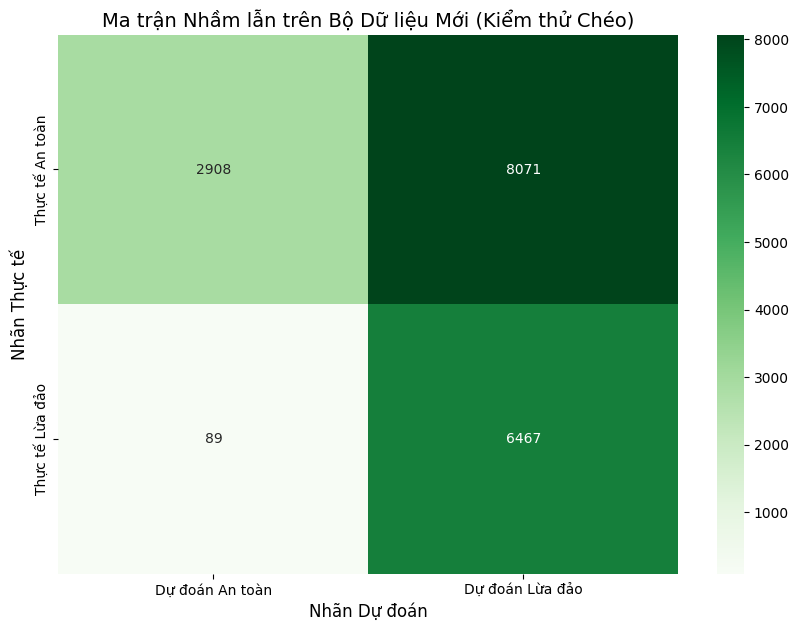

In [14]:
# Cell 3 (Phiên bản sửa lỗi nhanh)

# THÊM CÁC DÒNG IMPORT NÀY VÀO ĐẦU CELL
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# --------------------------------------------

if 'X_final_new' in locals() and 'y_true_new' in locals():
    print("--- Bắt đầu thực hiện dự đoán trên bộ dữ liệu mới ---")
    
    # Dùng mô hình đã được huấn luyện để dự đoán trên "đề thi mới"
    predictions_new = xgb_model_loaded.predict(X_final_new)
    
    print("--- Dự đoán hoàn tất! ---")

    # --- PHÂN TÍCH KẾT QUẢ ---
    
    # 1. Báo cáo đánh giá chi tiết
    print("\n--- BÁO CÁO ĐÁNH GIÁ TRÊN BỘ DỮ LIỆU MỚI (CROSS-VALIDATION) ---")
    # In ra các chỉ số Precision, Recall, F1-score
    report = classification_report(y_true_new, predictions_new, target_names=['An toàn (Safe)', 'Lừa đảo (Phishing)'])
    print(report)

    # 2. Vẽ ma trận nhầm lẫn để xem chi tiết lỗi
    cm_new = confusion_matrix(y_true_new, predictions_new)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Greens', 
                xticklabels=['Dự đoán An toàn', 'Dự đoán Lừa đảo'], 
                yticklabels=['Thực tế An toàn', 'Thực tế Lừa đảo'])
    plt.xlabel('Nhãn Dự đoán', fontsize=12)
    plt.ylabel('Nhãn Thực tế', fontsize=12)
    plt.title('Ma trận Nhầm lẫn trên Bộ Dữ liệu Mới (Kiểm thử Chéo)', fontsize=14)
    plt.show()

else:
    print("Dữ liệu kiểm thử mới (X_final_new) chưa được tạo. Vui lòng chạy Cell 2 trước.")